In [3]:
!nvidia-smi

Thu Sep  5 07:38:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
!pip install segment-geospatial

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.1 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.9/52.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 482.8/482.8 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 111.8 MB/s eta

In [5]:
import os
import leafmap
from samgeo import SamGeo, show_image, download_file, overlay_images, tms_to_geotiff

In [6]:
# create an interactive map
m = leafmap.Map(center=[10.777133256034274, 106.66882151130577], zoom=17, height="800px")
m.add_basemap("SATELLITE")
m

Map(center=[10.777133256034274, 106.66882151130577], controls=(ZoomControl(options=['position', 'zoom_in_text'…

#### Navigate and magnify the map to pinpoint the area of focus

In [7]:
if m.user_roi_bounds() is not None:
  bbox = m.user_roi_bounds()
else:
  bbox = [106.667, 10.7761, 106.6717, 10.7785]

In [8]:
# download sample image

image = "satellite.tif"
leafmap.tms_to_geotiff(output=image, bbox=bbox, zoom=17, source="Satellite", overwrite=True)

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to satellite.tif


In [9]:
m.layers[-1].visible = False
m.add_raster(image, layer_name="Image")
m

Map(center=[10.7773, 106.66935000000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_…

In [10]:
# initialize sam2 class by providing the file path to model checkpoint

sam = SamGeo(
    model_type = "vit_h",
    sam_kwargs = None
)

Model checkpoint for vit_h not found.


Downloading...
From: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
To: /root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth
100%|██████████| 2.56G/2.56G [00:24<00:00, 103MB/s] 


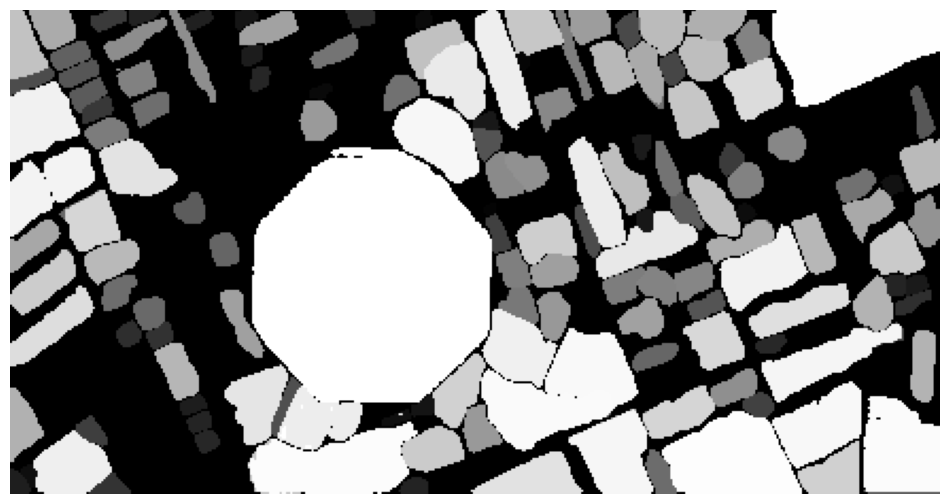

In [11]:
# automated mask creation
sam.generate(image, output="masks.tif", foreground=True, unique=True)
sam.show_masks(cmap="binary_r")

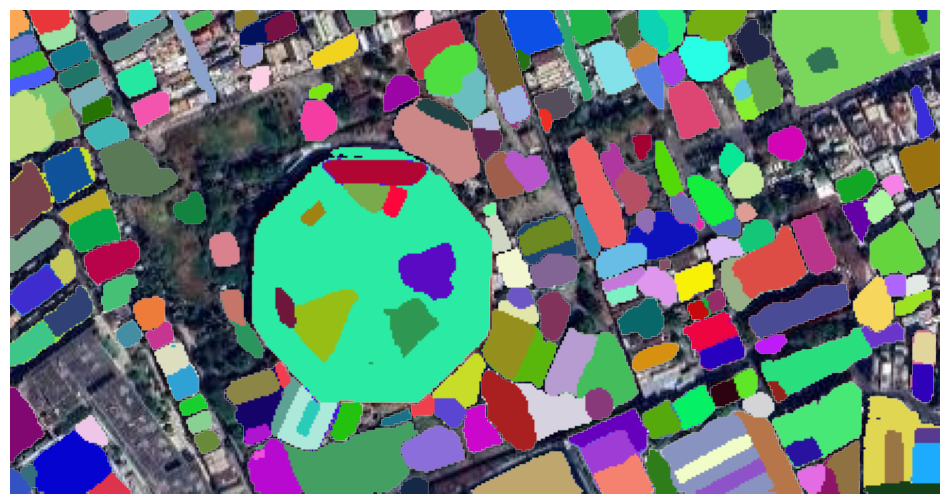

In [12]:
# we can actually view the annotations also
sam.show_anns(alpha=1, axis="off", output="annotations.tif")


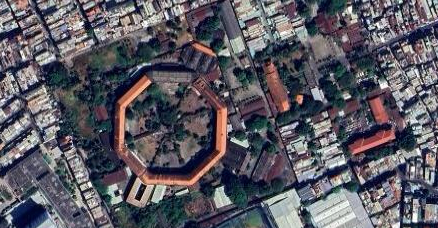
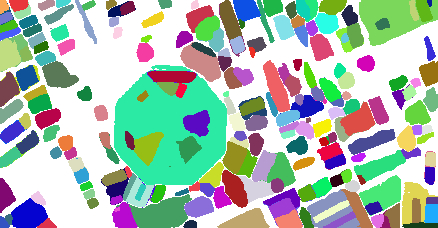

In [13]:
# compare the image
leafmap.image_comparison(
    "satellite.tif",
    "annotations.tif",
    label1 = "Satellite Image",
    label2 = "Image Segmentation"
)

In [14]:
# add image to the map
m.add_raster("annotations.tif", alpha=0.5, layer_name="Masks")
m

Map(center=[10.7773, 106.66935000000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_…

In [15]:
# i'm gonna convert this object annotation to vector format
sam.tiff_to_vector("masks.tif", "masks.gpkg")

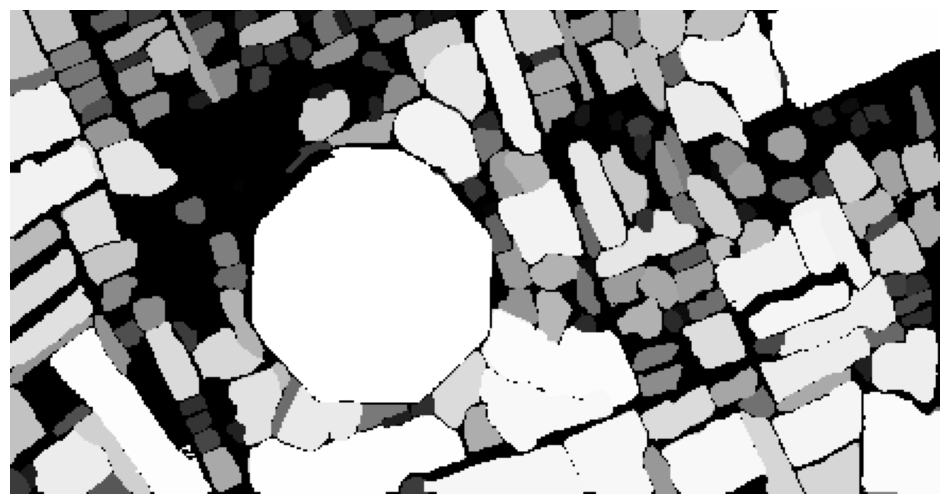

In [16]:
# Automatic mask generation

sam_kwargs = {
    "points_per_side": 32,
    "pred_iou_thresh": 0.86,
    "stability_score_thresh": 0.92,
    "crop_n_layers": 1,
    "crop_n_points_downscale_factor": 2,
    "min_mask_region_area": 100,
}

sam = SamGeo(
    model_type = "vit_h",
    sam_kwargs = sam_kwargs
)

sam.generate(image, output="masks2.tif", foreground=True)
sam.show_masks(cmap="binary_r")

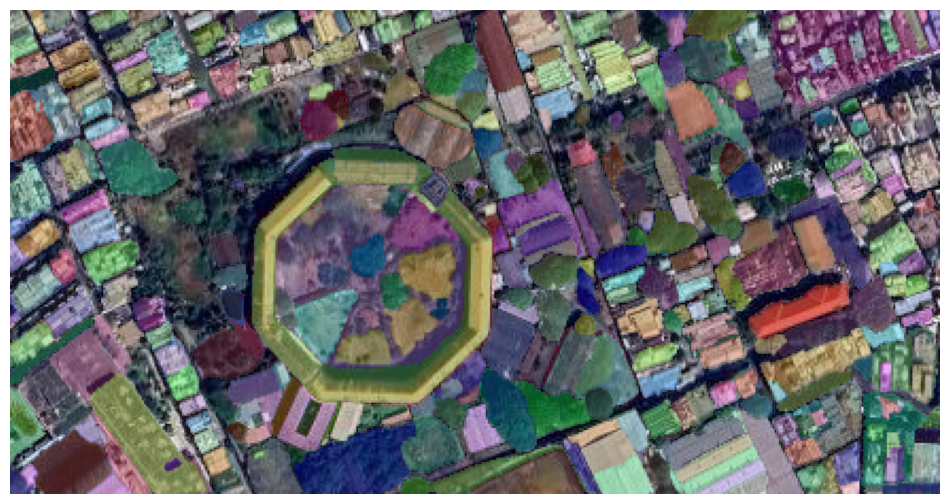

In [17]:
sam.show_anns(axis = "off", opacity=1, output="annotations2.tif")


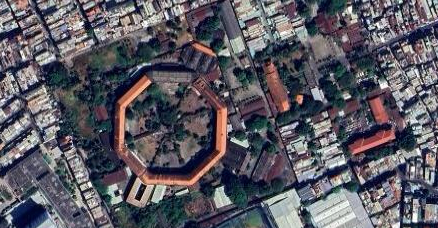
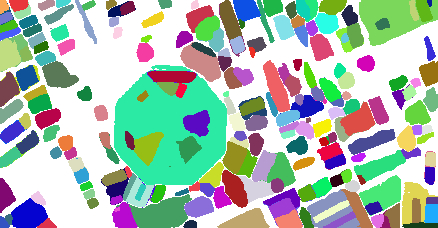

In [18]:
# compare two images
leafmap.image_comparison(
    image,
    "annotations.tif",
    label1="Image",
    label2="Image Segmentation",
)

In [19]:
overlay_images(image, "annotations2.tif", backend="TkAgg")

The TkAgg backend is not supported in Google Colab. The overlay_images function will not work on Colab.
